# DeepGhostBusters: Performance Evaluation

In this notebook we load the Mask R-CNN model (DeepGhostBuster) we trained in a separate notebook, and we perfrorm and number of tests in order to quantify its ability to detect ghosting artifacts.

We use both conventional object detection metrics (such as the mean Average Precision - mAP) and custom metrics, such as the CCD-based Precision and Recall; these evaluate the performance of DeepGhostBusters in a less granular level that is more appropriate for problem at hand and allow the comparison between DeepGhosBuster and the ray tracing algorithm.

We discuss these metrics in detail below.

In [79]:
# Import basic packages 
import numpy as np 
import scipy as scipy 
import os
import sys
import json
import datetime
from PIL import Image
import skimage.draw
import numpy.ma as ma
import imageio
import cv2

# Specific functions from packages
from scipy.interpolate import interp1d 

#import tensorflow 1
%tensorflow_version 1.x
import keras

# Scikit-learn for evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# Colab in order to be able to download files
from google.colab import files

# Matplotlib, seaborn and plot pretty 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

Un-comment and run the following lines in order to install packages that 
allow LaTeX to be used in matplotlib (process of labels).

In [2]:
#!pip install 'h5py==2.10.0' --force-reinstall

In [4]:
#! sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#!apt install cm-super

In [5]:
# Import drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd drive/MyDrive/
!pwd
!pip install fitsio

/content/drive/MyDrive
/content/drive/MyDrive
     |████████████████████████████████| 5.0MB 8.3MB/s 
  Created wheel for fitsio: filename=fitsio-1.1.4-cp37-cp37m-linux_x86_64.whl size=1778777 sha256=44511260854dc0f3dde5a64d7431acb67e67a8bd81135b798245bbea018667a3
  Stored in directory: /root/.cache/pip/wheels/22/41/8e/36c7c16edc7fd0ecc4aa3064c565d1b62152f2ff58ac567266
Successfully built fitsio


**Import Mask R-CNN**


In [7]:
# To find the path for Mask_RCNN
sys.path.insert(1, 'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Import Field-of-View Geometry 
# this is in order to get the limits of the CCDs
from run import fov_geometry

# To load datasets
# In a form that can be easily used in mAP calculations
from Ghost_load import GhostsDataset

In [8]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "MyDrive/Mask_RCNN/logs")

# Local path to trained weights file - Mask R-CNN
# This can change and we can use trained of more shallow 
GHOST_MODEL_PATH = os.path.join(ROOT_DIR, "MyDrive/Mask_RCNN/mask_rcnn_Ghosts.h5")

In [9]:
# Notebook preferences
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Configurations

Here we create a class that overrides some of the Mask R-CNN model configurations we have to change.

In [10]:
# This class can be further edited

class GhostsConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Type"
 
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + three ghost categories

    # Learning rate - DEFAULT = 0.004
    LEARNING_RATE = 0.004

    # How to resize the image
    # Use "none" if you don't want to resize
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Maximum number of ground truth instances (objects) in one image
    MAX_GT_INSTANCES = 100
    DETECTION_MAX_INSTANCES = 100

 
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 150
 
    # Skip detections with < 80% confidence
    DETECTION_MIN_CONFIDENCE = 0.8

config = GhostsConfig()

# Uncomment the following line, if you want to see the values of all the 
# configuration parameters (including the default values)
#config.display() 

# =====================================================================
# =====================================================================
class InferenceConfig(GhostsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights
print("Loading weights from ", GHOST_MODEL_PATH)
model.load_weights(GHOST_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/drive/MyDrive/Mask_RCNN/mask_rcnn_Ghosts.h5


**One detection example:**

In [11]:
# Directory of images to run detection on
IMAGE_DIR = "Plots"
# Load a random image from the images folder
file_names = 'Ghost_Img.jpg'
image = skimage.io.imread(os.path.join(IMAGE_DIR, file_names))

Processing 1 images
image                    shape: (400, 400, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



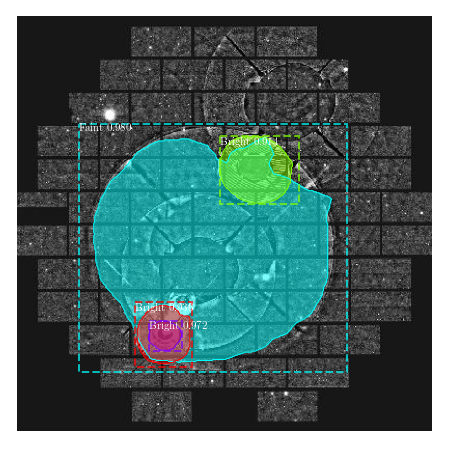

In [12]:
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                           ['Rays','Bright','Faint'], r['scores'], ax=get_ax())

## Part I: CCD-based Precision, Recall, and F1 score

In the following section we will consider some commonly used object detection evaluation metrics; in the present section we would like to define some alternative metrics that we think are appropriate for the problem at hand.

The DECam focal plane consists of 62 CCDs. In each one of them a ghost may or may not be present. Current algorithms that are used to track and remove ghosting artifacts flag bad CCDs; thus if we want to compare their performance to a Mask R-CNN based approach developing metrics that are based on whether a CCD contains a ghosting artifact or not. 

Furthermore, given the challenges of this problem (overlapping sources, borders of objects not always well defined) assessing the performance at a less granualar level (complared, for example, to the overlap of the predicted and true mask of an object) is more appropriate.



---



---


Let's assume that we have a batch of $M$ images, each one containing 62 CCDs, so $N = 62\times M$ CCDs in total. These $M$ images can be those in the training, validation, and test sets, for example.

Let's  now define as ``positives`` those CCDs containing a ghost and ``negatives`` those that do not. Note that we can have such a definition for each type of ghosts separately or for all types of ghosts, combined (i.e. a CCD containing any ghost or a CCD containing a specific type of ghosts, e.g. "Rays"). 

We can then define the following:

- True Positives, $N^{TP}$: Number of CCDs predicted to contain a ghost that actually contain a ghost.

- True Negatives, $N^{TN}$: Number of CCDs predicted not to contain a ghost and actually do not contain one (ground truth).

- False Postives, $N^{FP}$: Number of CCDs predicted to contain a ghost that do not actually contain one.

- False Negatives, $N^{FN}$: Number of CCDs predicted not to contain a ghost that actually contain one.

Then, based on these we can define the *CCD*-based Precision (purity), Recall (completeness), and F1 scores as:



\begin{equation}
Precision_{\scriptsize{CCD}} = \frac{N^{TP}}{N^{TP}+N^{FP}}
\end{equation}

\\

\begin{equation}
Recall_{\scriptsize{CCD}} = \frac{N^{TP}}{N^{TP}+N^{FN}}
\end{equation}

\\
The $F1$ score is the harmonic mean of precision and recall:
\begin{equation}
F1 = 2\frac{Precision_{\scriptsize{CCD}}\cdot Recall_{\scriptsize{CCD}}}{Precision_{\scriptsize{CCD}}+Recall_{\scriptsize{CCD}}}
\end{equation}

\\
Note that we **do not** try to define a CCD-based accuracy, since the problem is imbalanced; most CCDs are (ground truth or predicted) `negative` than `positive`; object detection methods are not not optimized for binary classification problems.


A final, but ***very important*** note: all these definitions above depend on the concept of a CCD "containing" a ghost, or not. But how do we define that?

We define that a CCD contains a ghost if it covers more than a threshold (as a percentage of the area of a CCD). Then we can estimate the evaluation metrics as a function of that threshold.


**Import CCD coordinates**

`Name` of CCDs is in the range 1-62

Then we have the min and max (pixel) coordinates for each one of these CCDs

In [13]:
# Get CCDs
ccds = np.asarray(fov_geometry(release='y1a1',size=[400,400]))

print(np.shape(ccds))

name = ccds[:,0]
x_min = ccds[:,1]
y_min = ccds[:,2]
x_max = ccds[:,3]
y_max = ccds[:,4]

x_min_pr = x_min + (x_min-200)*38.5*0.0025
x_max_pr = x_max + (x_max-200)*38.5*0.0025

(62, 5)


Let's esimate the dimensions (in pixels) of a single CCD.

Let's find the difference between the `y_max` and `y_min` and also `x_max` and `x_min`.

That way we can define are thersholds (as percentages) for defining that a CCD "contains" a ghost or not.

In [14]:
print(np.mean(y_max-y_min))
print(np.mean(x_max_pr-x_min_pr))

# So the number of pixels within a CCD is:

print("Number of pixels within CCD:",32*60.11695)

32.0
60.116935483870954
Number of pixels within CCD: 1923.7424


First define a function that creates masks for the three types of ghost,

- Returns an $400\times 400$ mask for each type of ghost

In [15]:
# Define function that creates mask for the Ghosts 
# for one specific image
def masking(regions,n_ghosts,get_masks=True):
  """
  Inputs: "regions": Dictionary that contain the types and coordinates 
          of the masks for one image.
          n_ghosts: Number of ghosts in the image 
  Outputs: Arrays (400x400) for the three categories of ghosts, that have ones 
          ("1") in the places of the masks and zeros ("0") everywhere else
  """
  #Initialize three different masks - one for each type of ghosts
  X_mask_rays = np.zeros([400,400])
  X_mask_bright = np.zeros([400,400])
  X_mask_faint = np.zeros([400,400])

  for j in range(n_ghosts):
    regions_loc = regions[j]

    # ==========================================
    # ==========================================
    # First get ghost types
    Type_loc = regions_loc['region_attributes']['Type']

    # Get shape attributes
    shape_attrs = regions_loc['shape_attributes']

    # Get the name of the shape attribute
    name = shape_attrs['name']
    # =====================================================
    # =====================================================
    
    if (name=='polyline'):
      rr, cc = skimage.draw.polygon(shape_attrs['all_points_y'], shape_attrs['all_points_x'])
      a = (rr<400)&(cc<400)
    elif (name=='polygon'):
      rr, cc = skimage.draw.polygon(shape_attrs['all_points_y'], shape_attrs['all_points_x'])
      a = (rr<400)&(cc<400)
    elif (name=='rect'):
      rr, cc = skimage.draw.rectangle(start=(shape_attrs['y'], shape_attrs['x']),
                              extent=(shape_attrs['height'],shape_attrs['width']))
      a = (rr<400)&(cc<400)
    elif (name=='circle'):
      rr, cc = skimage.draw.circle(shape_attrs['cy'],shape_attrs['cx'],shape_attrs['r'])
      a = (rr<400)&(cc<400)
    elif (name=='ellipse'): 
      rr, cc = skimage.draw.ellipse(shape_attrs['cy'],shape_attrs['cx'],
                                      shape_attrs['ry'],shape_attrs['rx'],
                                      shape=None,rotation=-shape_attrs['theta'])
      a = (rr<400)&(cc<400)
    # ========================================================
    # ========================================================
    if (Type_loc=='Rays'):
      X_mask_rays[rr[a], cc[a]] = 1
    elif (Type_loc=='Bright'):
      X_mask_bright[rr[a], cc[a]] = 1
    elif (Type_loc=='Faint'):
      X_mask_faint[rr[a], cc[a]] = 1

  # ===========================================================
  # ===========================================================
  if (get_masks==False):
    # In this case you don't return the mask; just the matrices
    return X_mask_rays, X_mask_bright, X_mask_faint


  X_mask_rays = ma.masked_where(X_mask_rays<1, X_mask_rays) 
  X_mask_bright = ma.masked_where(X_mask_bright<1, X_mask_bright)
  X_mask_faint = ma.masked_where(X_mask_faint<1, X_mask_faint)

  return X_mask_rays, X_mask_bright, X_mask_faint

Now we write a function that gets a dataset, a percentage and returns evaluation metrics

In [16]:
 # General path for the directory where Training/Validation/Test sets are
dataset_dir = os.path.join(ROOT_DIR, "MyDrive/Dataset")

def evaluation_CCD(subset, percentage):
  """
  Inputs: subset: One of the Training, Validation or Test sets
          percentage: the number of pixels (as a percentage of the number 
          of pixels in a CCD) a ghost should cover in order to count a CCD as 
          ghost-containing
  Outputs: The CCD-based evaluation metrics
  """

  # Check that it is one of the Training, Validation or Test sets
  assert subset in ["Training_set", "Validation_set", "Test_set"]

  # Find directorty of the subset
  dataset_loc = os.path.join(dataset_dir, subset)

  # Load annotations
  annotations = json.load(open(os.path.join(dataset_loc, "via_region_data.json")))
  
  # ==========================================
  # Print the number of images
  n_img = len(annotations)
  #print("Number of images in the set:", n_img)


  # ============================================================
  # Set CCD area threshold (in pixels) that defines what is considered 
  # to contain a ghost - it should be *at least* one pixel

  n_pix_thres = max(1,32.0*60.1169*percentage)

  # ===========================================================
  # ===========================================================
  # Create empty arrays for the the ground truth label for each image and each CCD
  True_CCDs_rays = np.zeros([n_img,62]) # For rays
  True_CCDs_bright = np.zeros([n_img,62]) # For bright
  True_CCDs_faint = np.zeros([n_img,62]) # For faint

  # Create empty arrays for the predictions, for each image and each CCD
  Pred_CCDs_rays = np.zeros([n_img,62]) # For rays
  Pred_CCDs_bright = np.zeros([n_img,62]) # For bright
  Pred_CCDs_faint = np.zeros([n_img,62]) # For faint

  # ===================================
  # For combined types of ghosts - true and predictions

  # For ground truth labels
  True_CCDs_ray_bright = np.zeros([n_img,62]) # Rays + Bright ghosts
  True_CCDs_all = np.zeros([n_img,62]) # All ghosts

  # For predictions
  Pred_CCDs_ray_bright = np.zeros([n_img,62]) # Rays + Bright ghosts
  Pred_CCDs_all = np.zeros([n_img,62]) # All ghosts

  # ===========================================================
  # ===========================================================
  # Now we should populate both the True and Predicted arrays
  # Work for each one of the images
  for i in range(n_img):
    # Get the annotations of the i-th image
    img_annotations = annotations[i]

    # === Filename and exposure number ========================
    
    # Get filename
    filename = img_annotations['filename']
    
    # Get exposure number - split the string
    expnum_loc = int(filename[13:19])
    
    # =========================================================
    # =========================================================
    # ============== For ground truth first ===================

    # Start by getting the masks

    # Get regions - pretty much the description of the annotations
    regions = img_annotations['regions']  
    # Now get the number of ghosts
    n_ghosts = len(regions)

    # Create two dimentional array that contains 
    # the ghost masks 
    X_rays, X_bright, X_faint = masking(regions,n_ghosts)


    # =================================================== 
    # Now for combined ghost masks

    # Get again matrices with 0/1
    X_rays_m, X_bright_m, X_faint_m = masking(regions,n_ghosts,get_masks=False)

    X_mask_ray_bright = X_rays_m + X_bright_m
    X_mask_all = X_rays_m + X_bright_m + X_faint_m

    # Now make the matrices binary again
    X_mask_ray_bright[X_mask_ray_bright>1.] = 1.
    X_mask_all[X_mask_all>1.] = 1.

    # Get masks for the combined ghosts
    X_mask_ray_bright = ma.masked_where(X_mask_ray_bright<1, X_mask_ray_bright) # Rays + Bright
    X_mask_all = ma.masked_where(X_mask_all<1, X_mask_all) # All ghosts
    
    # ======================================================
    # ============ Find affected CCDs ======================
    for k in range(62):
      CCD_loc = k # Local number of CCD

      # For rays
      loc_mask_rays = X_rays[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]
      if (np.sum(loc_mask_rays)>n_pix_thres):
        True_CCDs_rays[i,k] = 1.0
      # For bright
      loc_mask_bright = X_bright[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]
      if (np.sum(loc_mask_bright)>n_pix_thres):
        True_CCDs_bright[i,k] = 1.0
      # For faint
      loc_mask_faint = X_faint[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]
      if (np.sum(loc_mask_faint)>n_pix_thres):
        True_CCDs_faint[i,k] = 1.0
      # For rays + bright
      loc_mask_ray_bright = X_mask_ray_bright[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]
      if (np.sum(loc_mask_ray_bright)>n_pix_thres):
        True_CCDs_ray_bright[i,k] = 1.0
      # For all ghosts types combined
      loc_mask_all = X_mask_all[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]
      if (np.sum(loc_mask_all)>n_pix_thres):
        True_CCDs_all[i,k] = 1.0

    # =========================================================
    # =========================================================
    # ================== For predictions now ==================

    # Get image 
    image = skimage.io.imread(os.path.join(dataset_loc, filename))

    # Run predictions
    results = model.detect([image], verbose=0)
    r = results[0]

    # Get ghosts masks - shape 400x400x(number of ghosts)
    rcnn_masks = r['masks']

    # Get the class ids of ghosts 1=Bright, 2=Faint, 3=Rays
    ghost_classes = r['class_ids']

    # =========================================================
    # Number of predicted ghosting artifacts
    n_ghosts = len(ghost_classes)

    
    for k in range(62):
      CCD_loc = k # Local number of CCD

      
      # Now run over ghosts 
      for j in range(n_ghosts):

        # Get the local mask - for the j-th ghost
        X_mask_jth = rcnn_masks[:,:,j]
        # Get the type (class) of the j-th ghost 
        class_jth = ghost_classes[j]

        loc_mask = X_mask_jth[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]

        # The following can change 
        if (np.sum(loc_mask)>n_pix_thres):

          if (class_jth==1):
            Pred_CCDs_bright[i,k] = 1.
          elif (class_jth==2):
            Pred_CCDs_faint[i,k] = 1.
          elif (class_jth==3):
            Pred_CCDs_rays[i,k] = 1.
    # =================================================
    # Now for the combinations (rays+bright) and (rays+bright+faint)

    # Create empty arrays
    X_ray_bright_pred = np.full((400,400),False,dtype=bool) # Rays+Bright
    X_all_pred = np.full((400,400),False,dtype=bool) # Rays+Bright+Fain (all ghosts)

    # Run over ghosts 
    for j in range(n_ghosts):
      # Get the j-th mask, for the j-th ghost
      X_mask_jth = rcnn_masks[:,:,j] 
      # Get the type (class) of the j-th ghost 
      class_jth = ghost_classes[j]

      # Update matrices
      X_all_pred += X_mask_jth # This is always updated
      
      # Update the 'ray-bright' mask if the ghost is not of type "faint"
      if (class_jth!=2): 
        X_ray_bright_pred += X_mask_jth 
    # =====================================
    # Run over CCDs 
    for k in range(62):
      CCD_loc = k # Local number of CCD


      # Get "local" masks - corresponding to the region of the CCD 
      loc_ray_bright_pred = X_ray_bright_pred[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]
      loc_all_pred = X_all_pred[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]

      # Now change the CCD values if the masks pass the threshold
      if (np.sum(loc_ray_bright_pred)>n_pix_thres):
        Pred_CCDs_ray_bright[i,k] = 1.
      if (np.sum(loc_all_pred)>n_pix_thres):
        Pred_CCDs_all[i,k] = 1.
        
  # ============================================================================
  # ============================================================================
  # Flatten the populated arrays

  # First for the individual ghost types 

  # True values
  y_rays_true = True_CCDs_rays.flatten()
  y_bright_true = True_CCDs_bright.flatten()
  y_faint_true = True_CCDs_faint.flatten()
  # Predicted values
  y_rays_pred = Pred_CCDs_rays.flatten()
  y_bright_pred = Pred_CCDs_bright.flatten()
  y_faint_pred = Pred_CCDs_faint.flatten()


  # ===============================================
  # Now for the combination of ghosts

  # True
  y_ray_bright_true = True_CCDs_ray_bright.flatten()
  y_all_true = True_CCDs_all.flatten()

  # Predicted 
  y_ray_bright_pred = Pred_CCDs_ray_bright.flatten()
  y_all_pred = Pred_CCDs_all.flatten()

  # ============================================================
  # ============================================================
  # Calculate evaluation metrics for each one of the ghost categories, separately
  
  prec_rays = precision_score(y_rays_true,y_rays_pred) #Precision, Rays
  rec_rays = recall_score(y_rays_true,y_rays_pred) # Recall, Rays
  F1_rays = f1_score(y_rays_true,y_rays_pred) # F_1 score, Rays
  prec_bright = precision_score(y_bright_true,y_bright_pred)# Precision, bright
  rec_bright = recall_score(y_bright_true,y_bright_pred) # Recall, bright
  F1_bright = f1_score(y_bright_true,y_bright_pred) # F_1 score, bright
  prec_faint = precision_score(y_faint_true,y_faint_pred) #Precision, faint
  rec_faint = recall_score(y_faint_true,y_faint_pred) #Recall, faint
  F1_faint = f1_score(y_faint_true,y_faint_pred) # F_1 score, faint


  # ============================================================
  # Calculate evaluation metrics for the combination of ghost categories

  prec_ray_bright = precision_score(y_ray_bright_true,y_ray_bright_pred) # Precision, rays+bright
  rec_ray_bright = recall_score(y_ray_bright_true,y_ray_bright_pred) # Recall, rays+bright
  F1_ray_bright = f1_score(y_ray_bright_true,y_ray_bright_pred) # F_1 score, rays+bright
  prec_all = precision_score(y_all_true,y_all_pred) # Precision, all ghosts
  rec_all = recall_score(y_all_true,y_all_pred) # Recall, all ghosts
  F1_all = f1_score(y_all_true,y_all_pred) # F_1 score, all ghosts


  metrics_rays = [prec_rays,rec_rays,F1_rays]
  metrics_bright = [prec_bright,rec_bright,F1_bright]
  metrics_faint =[prec_faint,rec_faint,F1_faint]
  metrics_ray_bright = [prec_ray_bright,rec_ray_bright,F1_ray_bright]
  metrics_all = [prec_all,rec_all,F1_all]

  return metrics_rays,metrics_bright,metrics_faint,metrics_ray_bright,metrics_all



In [17]:
perc_CCD = np.linspace(0,0.9,19)
n_perc = len(perc_CCD)
#print(perc_CCD)

# Store arrays of evaluation metrics

# Initialize
metrics_rays = np.zeros([n_perc,3]) 
metrics_bright = np.zeros([n_perc,3])
metrics_faint = np.zeros([n_perc,3])
metrics_ray_bright = np.zeros([n_perc,3])
metrics_all = np.zeros([n_perc,3])


for i in range(n_perc):
  perc_loc = perc_CCD[i]
  met_ray_loc, met_br_loc, met_fnt_loc, met_ray_br_loc, met_all =  evaluation_CCD("Test_set", perc_loc)
  metrics_rays[i,:] = met_ray_loc
  metrics_bright[i,:] = met_br_loc 
  metrics_faint[i,:] = met_fnt_loc
  metrics_ray_bright[i,:] = met_ray_br_loc
  metrics_all[i,:] = met_all

In [18]:
# Percentages 
percent = np.linspace(0,90,19)

**Precision/Recall for individual ghost types**

We start by making a plot for precision and recall as a function of the percentage of the area of a CCD a ghost should cover in order to say that a CCD contains a ghost.

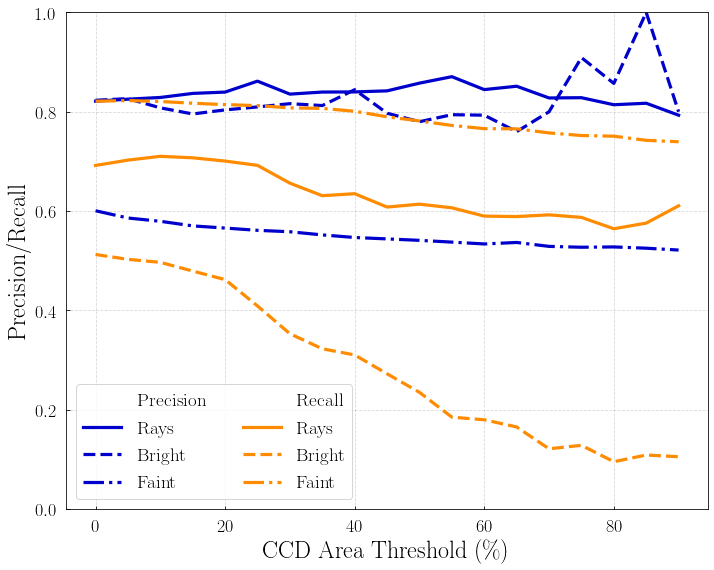

In [101]:
plt.figure(figsize=(10, 8))

# Precisions
plt.plot([],marker="", ls="", label='Precision')
plt.plot(percent,metrics_rays[:,0],c='mediumblue',linewidth=3.2,label='Rays')
plt.plot(percent,metrics_bright[:,0],c='mediumblue',ls='--',linewidth=3.2,label='Bright')
plt.plot(percent,metrics_faint[:,0],c='mediumblue',ls='-.',linewidth=3.2,label='Faint')


#Recalls
plt.plot([],marker="", ls="", label='Recall')
plt.plot(percent,metrics_rays[:,1],c='darkorange',linewidth=3.2,label='Rays')
plt.plot(percent,metrics_bright[:,1],c='darkorange',ls='--',linewidth=3.2,label='Bright')
plt.plot(percent,metrics_faint[:,1],c='darkorange',ls='-.',linewidth=3.2,label='Faint')


# Legents/Labels etc
plt.legend(frameon=True, loc='lower left',ncol=2, fontsize=19)
plt.tick_params(axis='both', labelsize=18)
plt.xlabel('CCD Area Threshold ($\%$)',fontsize=24);plt.ylabel('Precision/Recall',fontsize=24)
plt.grid(ls='--',alpha=0.5)
plt.ylim(0.0,1.)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Metrics_Area.pdf")
#files.download("/content/drive/My Drive/Plots/Metrics_Area.pdf")
plt.show()

**Precision/Recall for combinations of ghost types**


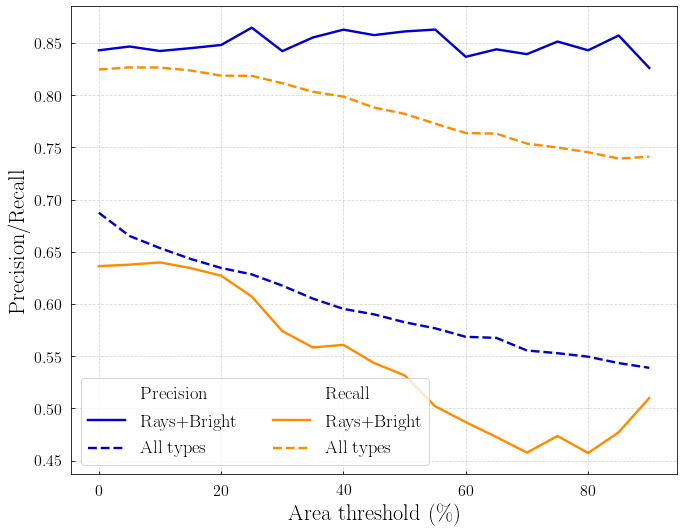

In [21]:
plt.figure(figsize=(9.6, 7.5))

# Precisions
plt.plot([],marker="", ls="", label='Precision')
plt.plot(percent,metrics_ray_bright[:,0],c='mediumblue',linewidth=2.4,label='Rays+Bright')
plt.plot(percent,metrics_all[:,0],c='mediumblue',ls='--',linewidth=2.4,label='All types')

# Recalls
plt.plot([],marker="", ls="", label='Recall')
plt.plot(percent,metrics_ray_bright[:,1],c='darkorange',linewidth=2.4,label='Rays+Bright')
plt.plot(percent,metrics_all[:,1],c='darkorange',ls='--',linewidth=2.4,label='All types')

# Legents/Labels etc
plt.legend(frameon=True, loc='lower left',ncol=2, fontsize=18.5)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Area threshold ($\%$)',fontsize=22.5);plt.ylabel('Precision/Recall',fontsize=22.5)
plt.grid(ls='--',alpha=0.5)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Metrics_Area_combined.pdf")
#files.download("/content/drive/My Drive/Plots/Metrics_Area_combined.pdf")
plt.show()

**F1 scores for all ghost types and combinations**

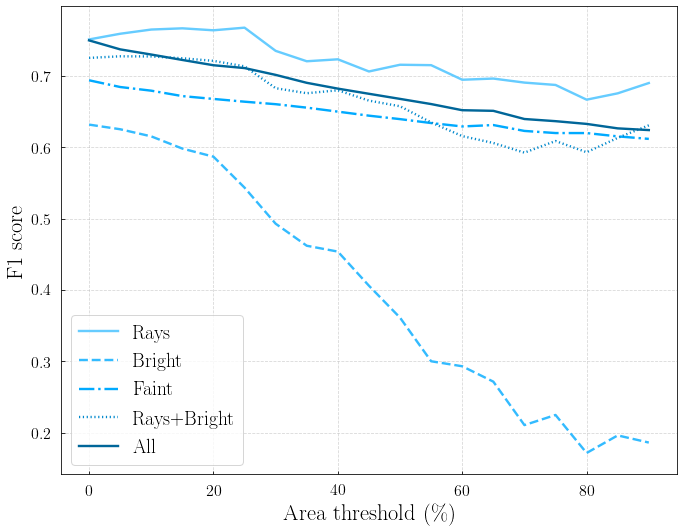

In [22]:
custom_blues = ["#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466"]

plt.figure(figsize=(9.6, 7.5))


# F1 score plots
plt.plot(percent,metrics_rays[:,2],c=custom_blues[0],linewidth=2.4,label='Rays')
plt.plot(percent,metrics_bright[:,2],c=custom_blues[1],ls='--',linewidth=2.4,label='Bright')
plt.plot(percent,metrics_faint[:,2],c=custom_blues[2],ls='-.',linewidth=2.4,label='Faint')
plt.plot(percent,metrics_ray_bright[:,2],c=custom_blues[3],ls=':',linewidth=2.4,label='Rays+Bright')
plt.plot(percent,metrics_all[:,2],c=custom_blues[4],linewidth=2.4,label='All')


# Legents/labels etc
plt.legend(frameon=True, loc='lower left',ncol=1, fontsize=19.5)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Area threshold ($\%$)',fontsize=22.5);plt.ylabel('F1 score',fontsize=22.5)
plt.grid(ls='--',alpha=0.5)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/F1_score_Area.pdf")
#files.download("/content/drive/My Drive/Plots/F1_score_Area.pdf")
plt.show()


**Now let's print the metrics at $0\%$, $5\%$, $10\%$, $15\%$, and $20\%$**.


- Precisions:

In [23]:
print('Presisions, Rays',metrics_rays[0:5,0])
print('Precisions, Bright',metrics_bright[0:5,0])
print('Precisions, Faint',metrics_faint[0:5,0])
print('Precisions, Rays+Bright',metrics_ray_bright[0:5,0])
print('Precisions, All',metrics_all[0:5,0])

Presisions, Rays [0.82135307 0.82535576 0.82881598 0.8369906  0.83965517]
Precisions, Bright [0.82311734 0.82648402 0.80789474 0.79559748 0.80377358]
Precisions, Faint [0.60063418 0.5860273  0.57943396 0.5701393  0.56579215]
Precisions, Rays+Bright [0.84294235 0.84660033 0.84230056 0.84502618 0.84805654]
Precisions, All [0.68738147 0.66523945 0.65358932 0.64321871 0.63454545]


- Recalls:

In [24]:
print('Recall, Rays',metrics_rays[0:5,1])
print('Recall, Bright',metrics_bright[0:5,1])
print('Recall, Faint',metrics_faint[0:5,1])
print('Recall, Rays+Bright',metrics_ray_bright[0:5,1])
print('Recall, All',metrics_all[0:5,1])

Recall, Rays [0.69189671 0.70264317 0.71026895 0.70728477 0.70071942]
Recall, Bright [0.51254089 0.50277778 0.49676375 0.47916667 0.46203905]
Recall, Faint [0.82131447 0.82253592 0.82068413 0.81721035 0.81440281]
Recall, Rays+Bright [0.63631816 0.63772642 0.63988724 0.63443396 0.6271777 ]
Recall, All [0.82464123 0.82660099 0.82647245 0.82364774 0.8186723 ]


- F1 scores:

In [25]:
print('F1, Rays',metrics_rays[0:5,2])
print('F1, Bright',metrics_bright[0:5,2])
print('F1, Faint',metrics_faint[0:5,2])
print('F1, Rays+Bright',metrics_ray_bright[0:5,2])
print('F1, All',metrics_all[0:5,2])

F1, Rays [0.75108748 0.75907198 0.76497696 0.7666906  0.76392157]
F1, Bright [0.63172043 0.62521589 0.61523046 0.59810875 0.58677686]
F1, Faint [0.69385001 0.6844258  0.6792745  0.67167456 0.66770671]
F1, Rays+Bright [0.72519954 0.72746705 0.72727273 0.72474181 0.72108162]
F1, All [0.74978121 0.73719357 0.72993381 0.72233657 0.71494418]


### Part Ib: Comparison with the Ray Tracing algorithm

As we said, one of the reasons we defined the CCD-based metrics above is because they allow us to compare the performance of the `DeepGhostBusters` Mask R-CNN algorithm with that of the Ray-tracing algorithm that is currently used to mask and remove ghosting artifacts in DES. We now turn into attention to the performance of this algorithm and calculate similar CCD-based precision and recall for it.

Let's discuss some important differences between the output of the Mask R-CNN and the Ray-tracing algorithms, that we have to have in mind when using the above metrics to compare the performance of the two.


-------------------------

First, remember that our annotations contain three categories of ghosting artifacts:

- `Bright`

- `Faint`

- `Rays`


The ray-tracing algorithm does not distinguish between them, however we suspect that it is not optimized to "pick" those characterized as faint. 

So, when calculating the above metrics, we can consider two cases: In the first case we include the faint ghosts from the `ground truth` catalog (our annotations), while in the second case we *do not* include these, so we evaluate precision/recall without taking into account the faint class. \\

Another difference in this case is that the Ray-Tracing algorithm predicts "bad" CCD (containing ghosts) directly; not masks. So in this case, when mapping predictions to CCDs we cannot put a threshold in the affected CCD area above which we consider it to contain a (predicted) ghost. However, in estimating the Precision and Recall, we have to consider the ground truth masks/bad CCDs, for which we need to define such a threshold.



--------------------------
First, import the files containing the exposure numbers (`expnum`) and the numbers representing the bad CCDs for each `expnum`, according to the ray tracing algorithm.

In [26]:
# Directory for Ray Tracing
RAY_DIR = os.path.join(ROOT_DIR, "MyDrive/Mask_RCNN/Ray_tracing")

# Import exposure number, ccd, ccd num for the ghosts from ray tracing
# from 
expnum_sv, ccd_sv, ccdnum_sv = np.loadtxt(os.path.join(RAY_DIR, "ghost-scatter-sv.txt"),  unpack=3, usecols=[1,2,4])
expnum_1, ccd_1, ccdnum_1 = np.loadtxt(os.path.join(RAY_DIR,"ghost-scatter-y1.txt"),  unpack=3, usecols=[1,2,4])
expnum_2, ccd_2, ccdnum_2 = np.loadtxt(os.path.join(RAY_DIR,"ghost-scatter-y2.txt"),  unpack=3, usecols=[1,2,4])
expnum_3, ccd_3, ccdnum_3 = np.loadtxt(os.path.join(RAY_DIR,"ghost-scatter-y3.txt"),  unpack=3, usecols=[1,2,4])
expnum_4, ccd_4, ccdnum_4 = np.loadtxt(os.path.join(RAY_DIR,"ghost-scatter-y4.txt"),  unpack=3, usecols=[1,2,4])
expnum_5, ccd_5, ccdnum_5 = np.loadtxt(os.path.join(RAY_DIR,"ghost-scatter-y5.txt"),  unpack=3, usecols=[1,2,4])
expnum_6, ccd_6, ccdnum_6 = np.loadtxt(os.path.join(RAY_DIR,"ghost-scatter-y6.txt"),  unpack=3, usecols=[1,2,4])

In [27]:
expnum = np.concatenate((expnum_sv,expnum_1,expnum_2,expnum_3,expnum_4,expnum_5,expnum_6)).astype(int)
ccd = np.concatenate((ccd_sv,ccd_1,ccd_2,ccd_3,ccd_4,ccd_5,ccd_6)).astype(int)
ccdnum = np.concatenate((ccdnum_sv,ccdnum_1,ccdnum_2,ccdnum_3,ccdnum_4,ccdnum_5,ccdnum_6)).astype(int)

Now write a function that calculates the CCD-based evaluation metrics of the Ray-Tracing algorithm, for a given dataset (Training/Validation/Test sets). 



Furthermore we include two options for which ghosts to include in the ground truth: With `consider_all = True` we consider all types of ghost (`Bright, Faint, Rays`) when estimating which CCDs contain (ground truth) ghosts; when `consider_all = False` we consider only `Bright` and `Rays`.

In [28]:
def evaluation_ray(subset,percentage,consider_all=True):
  """
  Inputs: subset: One of Training, Validation, or Test sets
          percentage: Percentage of a CCD a ghost should cover to be included
          consider_all: If 'True', all types of ghosting artifacts are being included
                        If 'False', only Rays and Bright are being included

  Outputs: Metrics (Precision, Recall, F_1 score)

  """
  # Check that it is one of the Training, Validation or Test sets
  assert subset in ["Training_set", "Validation_set", "Test_set"]

  # Find directorty of the subset
  dataset_loc = os.path.join(dataset_dir, subset)

  # Load annotations
  annotations = json.load(open(os.path.join(dataset_loc, "via_region_data.json")))
  
  # ==========================================
  # Get the number of images in the file
  n_img = len(annotations)
  #print("Number of images in the set:", n_img)

  # ============================================================
  # Set CCD area threshold (in pixels) that defines what is considered 
  # to contain a ghost for the ground truth - it should be *at least* one pixel

  n_pix_thres = max(1,32.0*60.1169*percentage)

  # ============================================================
  # ============================================================
  # Create empty arrays for the the ground truth label for each image and each CCD

  True_CCDs = np.zeros([n_img,62]) # Ground truth ghost-containing CCDs 
  Pred_CCDs_ray = np.zeros([n_img,62]) # Predicted ghost-containing CCDs, according to the ray-tracing algorithm

  for i in range(n_img):
    # Get the annotations of the i-th image
    img_annotations = annotations[i]

    # =============================================== 
    # === Filename and exposure number ==============
    
    # Get filename
    filename = img_annotations['filename']
    
    # Get exposure number - split the string
    expnum_loc = int(filename[13:19])
    # ================================================================
    # ================================================================
    # ======== Now work for the ground-truth masks ===================
    
    # Get regions - pretty much the description of the annotations
    regions = img_annotations['regions']  
    # Now get the number of ghosts
    n_ghosts = len(regions)
    
    # Create two dimentional array that contains 
    # the ghost mask
    X_rays, X_bright, X_faint = masking(regions,n_ghosts,get_masks=False)

    # Now combine the masks to create one ghost mask that contains:
    # All ghosts (rays,bright,faint) if `consider_all=True` *or*
    # Only (rays,bright) if `consider_all = False`

    if (consider_all==True):
      X_mask_ghost = X_rays + X_bright + X_faint
    elif (consider_all==False):
      X_mask_ghost = X_rays + X_bright

    
    # Now make the matrix binary again
    X_mask_ghost[X_mask_ghost>1.] = 1.

    # Get mask
    X_mask_ghost = ma.masked_where(X_mask_ghost<1, X_mask_ghost)   

    # ==============================================================
    # ============= Find affected CCDs =============================
    for k in range(62):
        CCD_loc = k # Local number of CCD
        
        loc_mask = X_mask_ghost[int(y_min[k]):int(y_max[k])+1,max(0,int(x_min_pr[k])):int(x_max_pr[k])+1]
        #print(np.shape(loc_mask))
        if (np.sum(loc_mask)>n_pix_thres):
          True_CCDs[i,k] = 1.0

    
    # ==============================================================
    # ========== Now get the affected CCDs =========================
    # ======== according to the ray tracing algorithm ==============

    Aff_ray = ccdnum[expnum==expnum_loc]-1
    Pred_CCDs_ray[i,Aff_ray] = 1.

  # ============================================================
  # ============================================================
  # Calculate evaluation metrics 

  # Flatten
  y_true = True_CCDs.flatten()
  y_pred = Pred_CCDs_ray.flatten()


  Precision = precision_score(y_true,y_pred)
  Recall = recall_score(y_true,y_pred)
  F1_score = f1_score(y_true,y_pred)

  metrics = [Precision, Recall, F1_score]

  return metrics 

In [29]:
perc_CCD = np.linspace(0,0.9,19)
n_perc = len(perc_CCD)

metrics_ray_bright_rt = np.zeros([n_perc,3]) # Metrics for Rays+Bright with the ray-tracing
metrics_all_rt = np.zeros([n_perc,3]) # Metrics for all ghosts with the ray-tracing

for i in range(n_perc):
  perc_loc = perc_CCD[i]
  metrics_ray_bright_rt[i,:] = evaluation_ray("Test_set", perc_loc,consider_all=False)
  metrics_all_rt[i,:] = evaluation_ray("Test_set", perc_loc,consider_all=True)




**Precision/Recall score plot**

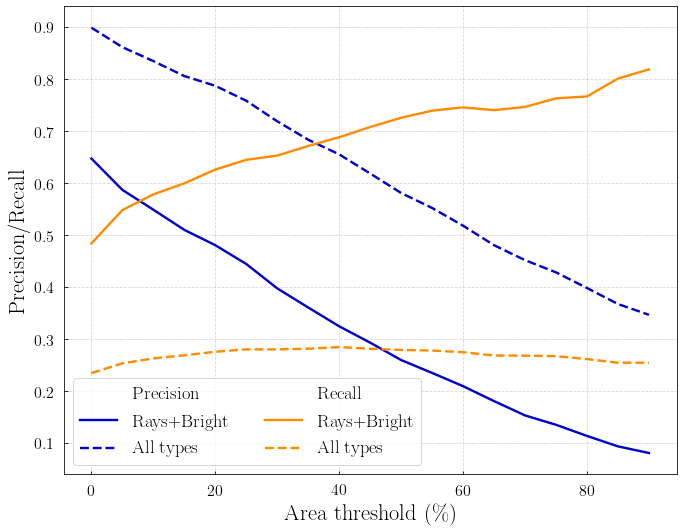

In [30]:
plt.figure(figsize=(9.6, 7.5))

# Precisions
plt.plot([],marker="", ls="", label='Precision')
plt.plot(percent,metrics_ray_bright_rt[:,0],c='mediumblue',linewidth=2.4,label='Rays+Bright')
plt.plot(percent,metrics_all_rt[:,0],c='mediumblue',ls='--',linewidth=2.4,label='All types')

# Recalls
plt.plot([],marker="", ls="", label='Recall')
plt.plot(percent,metrics_ray_bright_rt[:,1],c='darkorange',linewidth=2.4,label='Rays+Bright')
plt.plot(percent,metrics_all_rt[:,1],c='darkorange',ls='--',linewidth=2.4,label='All types')

# Legents/Labels etc
plt.legend(frameon=True, loc='lower left',ncol=2, fontsize=18.5)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Area threshold ($\%$)',fontsize=22.5);plt.ylabel('Precision/Recall',fontsize=22.5)
plt.grid(ls='--',alpha=0.5)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Metrics_Area_ray_tracing.pdf")
#files.download("/content/drive/My Drive/Plots/Metrics_Area_ray_tracing.pdf")
plt.show()

**Plot of F1 score**

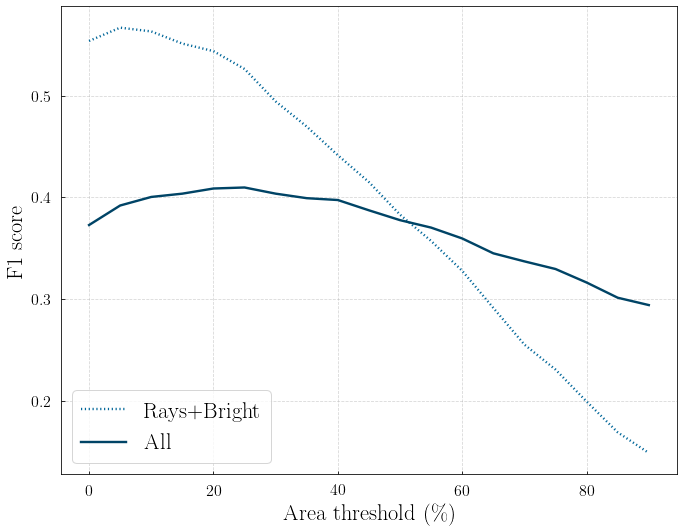

In [31]:
custom_blues = ["#006699", "#004466"]
plt.figure(figsize=(9.6, 7.5))


# F1 score plots
plt.plot(percent,metrics_ray_bright_rt[:,2],custom_blues[0],ls=':',linewidth=2.4,label='Rays+Bright')
plt.plot(percent,metrics_all_rt[:,2],c=custom_blues[1],linewidth=2.4,label='All')


# Legents/labels etc
plt.legend(frameon=True, loc='lower left',ncol=1, fontsize=22.5)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('Area threshold ($\%$)',fontsize=22.5);plt.ylabel('F1 score',fontsize=22.5)
plt.grid(ls='--',alpha=0.5)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/F1_score_ray_tracing.pdf")
#files.download("/content/drive/My Drive/Plots/F1_score_ray_tracing.pdf")
plt.show()


**Now let's print the metrics at $0\%$, $5\%$, $10\%$, $15\%$, and $20\%$**.


- Precisions:

In [32]:
print('Presisions, Ray+Bright',metrics_ray_bright_rt[0:5,0])
print('Precisions, all ghosts',metrics_all[0:5,0])

Presisions, Ray+Bright [0.64749164 0.58729097 0.54916388 0.51036789 0.48093645]
Precisions, all ghosts [0.68738147 0.66523945 0.65358932 0.64321871 0.63454545]


- Recall:

In [33]:
print('Recall, Ray+Bright',metrics_ray_bright_rt[0:5,1])
print('Recall, all ghosts',metrics_all[0:5,1])

Recall, Ray+Bright [0.48424212 0.54840725 0.57857646 0.59984277 0.62630662]
Recall, all ghosts [0.82464123 0.82660099 0.82647245 0.82364774 0.8186723 ]


- F1 score:

In [34]:
print('F1 score, Ray+Bright',metrics_ray_bright_rt[0:5,2])
print('F1 score, all ghosts',metrics_all[0:5,2])

F1 score, Ray+Bright [0.55409273 0.56718346 0.56348662 0.55149982 0.5440787 ]
F1 score, all ghosts [0.74978121 0.73719357 0.72993381 0.72233657 0.71494418]


### Combined Plots 

Here we present plots that combine the results from the Mask R-CNN algorithm and the Ray-Tracing algorithms.


- **Precisions**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

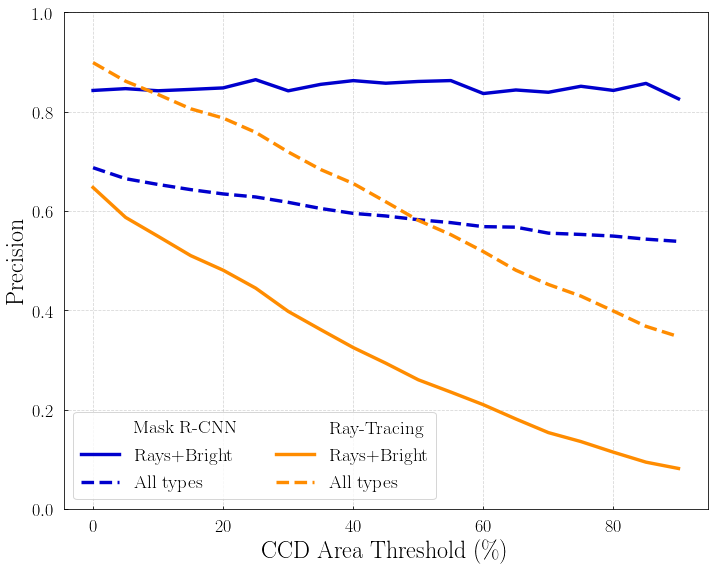

In [102]:
plt.figure(figsize=(10, 8))

# Precisions, Mask R-CNN
plt.plot([],marker="", ls="", label='Mask R-CNN')
plt.plot(percent,metrics_ray_bright[:,0],c='mediumblue',linewidth=3.4,label='Rays+Bright')
plt.plot(percent,metrics_all[:,0],c='mediumblue',ls='--',linewidth=3.4,label='All types')

# Precisions, Ray-Tracing
plt.plot([],marker="", ls="", label='Ray-Tracing')
plt.plot(percent,metrics_ray_bright_rt[:,0],c='darkorange',linewidth=3.4,label='Rays+Bright')
plt.plot(percent,metrics_all_rt[:,0],c='darkorange',ls='--',linewidth=3.4,label='All types')


# Legents/Labels etc
plt.legend(frameon=True, loc='lower left',ncol=2, fontsize=19)
plt.tick_params(axis='both', labelsize=18)
plt.xlabel('CCD Area Threshold ($\%$)',fontsize=24);plt.ylabel('Precision',fontsize=24)
plt.grid(ls='--',alpha=0.5)
plt.ylim(0.0,1.)


plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Precisions_Combined.pdf")
#files.download("/content/drive/My Drive/Plots/Precisions_Combined.pdf")
plt.show()

- **Recalls**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

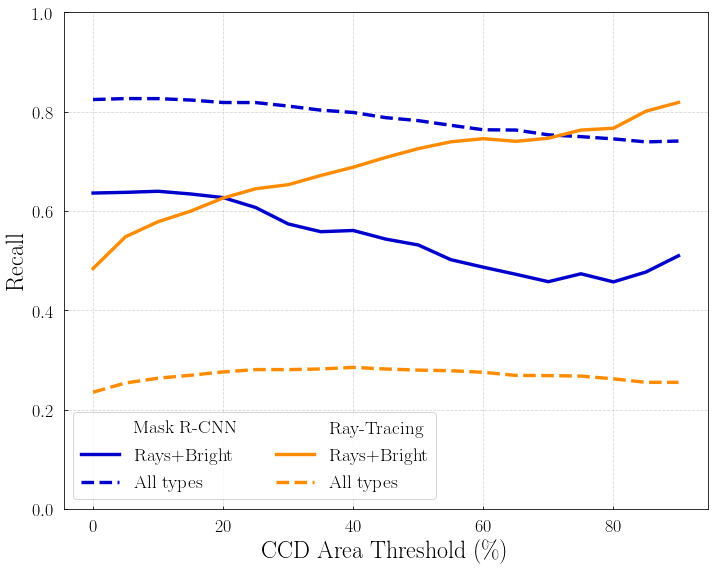

In [103]:
plt.figure(figsize=(10, 8))

# Recalls, Mask R-CNN
plt.plot([],marker="", ls="", label='Mask R-CNN')
plt.plot(percent,metrics_ray_bright[:,1],c='mediumblue',linewidth=3.4,label='Rays+Bright')
plt.plot(percent,metrics_all[:,1],c='mediumblue',ls='--',linewidth=3.4,label='All types')

# Recalls, Ray-Tracing
plt.plot([],marker="", ls="", label='Ray-Tracing')
plt.plot(percent,metrics_ray_bright_rt[:,1],c='darkorange',linewidth=3.4,label='Rays+Bright')
plt.plot(percent,metrics_all_rt[:,1],c='darkorange',ls='--',linewidth=3.4,label='All types')


# Legents/Labels etc
plt.legend(frameon=True, loc='lower left',ncol=2, fontsize=19)
plt.tick_params(axis='both', labelsize=18)
plt.xlabel('CCD Area Threshold ($\%$)',fontsize=24);plt.ylabel('Recall',fontsize=24)
plt.grid(ls='--',alpha=0.5)
plt.ylim(0.0,1.)



plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Recalls_Combined.pdf")
#files.download("/content/drive/My Drive/Plots/Recalls_Combined.pdf")
plt.show()

- **F1 score**

First individual ghost types from Mask R-CNN

In [104]:
custom_blues = ["#66CCFF", "#33BBFF", "#00AAFF", "#0088CC", "#006699", "#004466"]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

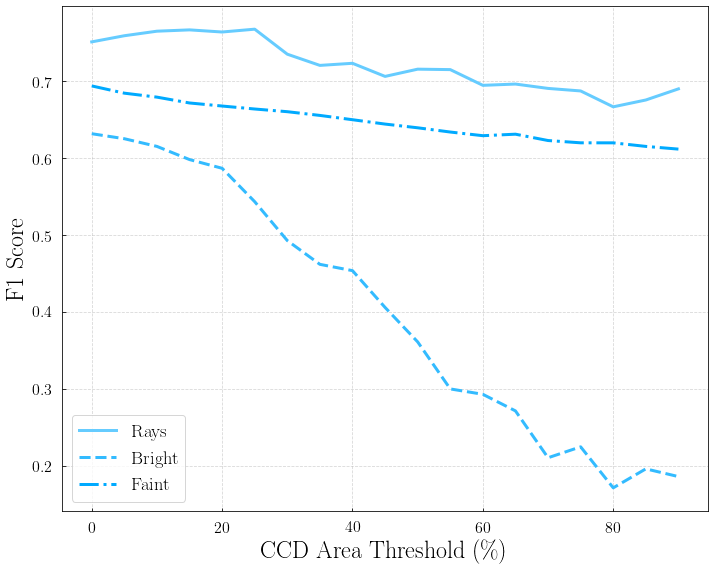

In [106]:
plt.figure(figsize=(10, 8))


# F1 score plots - Mask R-CNN
plt.plot(percent,metrics_rays[:,2],c=custom_blues[0],linewidth=3.0,label='Rays')
plt.plot(percent,metrics_bright[:,2],c=custom_blues[1],ls='--',linewidth=3.0,label='Bright')
plt.plot(percent,metrics_faint[:,2],c=custom_blues[2],ls='-.',linewidth=3.0,label='Faint')

# Legents/Labels etc
plt.legend(frameon=True, loc='lower left',ncol=1, fontsize=18.5)
plt.tick_params(axis='both', labelsize=16)
plt.xlabel('CCD Area Threshold ($\%$)',fontsize=24);plt.ylabel('F1 Score',fontsize=24)
plt.grid(ls='--',alpha=0.5)
#plt.ylim(0.0,1.)


plt.tight_layout()
plt.savefig("/content/drive/My Drive/Plots/F1_Individual.pdf")
files.download("/content/drive/My Drive/Plots/F1_Individual.pdf")
plt.show()

- Now F1 score comparison between Mask R-CNN and Ray-Tracing

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

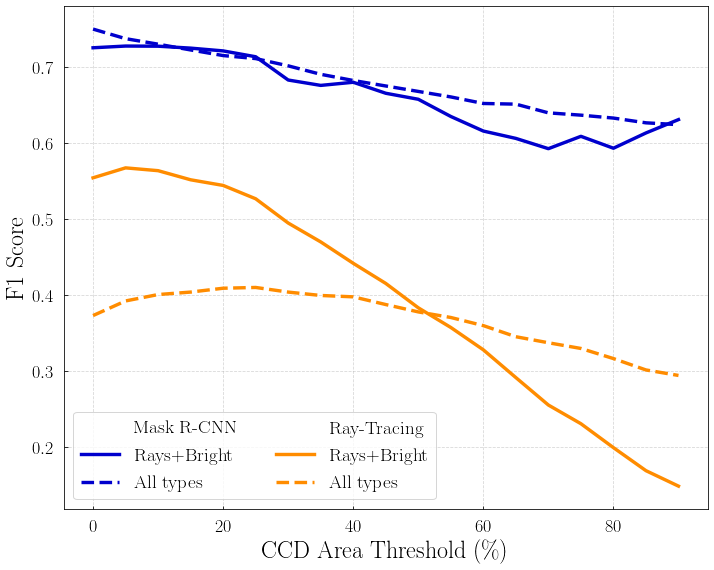

In [107]:
plt.figure(figsize=(10, 8))

# F1 score, Mask R-CNN
plt.plot([],marker="", ls="", label='Mask R-CNN')
plt.plot(percent,metrics_ray_bright[:,2],c='mediumblue',linewidth=3.4,label='Rays+Bright')
plt.plot(percent,metrics_all[:,2],c='mediumblue',ls='--',linewidth=3.4,label='All types')

# F1 score, Ray-Tracing
plt.plot([],marker="", ls="", label='Ray-Tracing')
plt.plot(percent,metrics_ray_bright_rt[:,2],c='darkorange',linewidth=3.4,label='Rays+Bright')
plt.plot(percent,metrics_all_rt[:,2],c='darkorange',ls='--',linewidth=3.4,label='All types')


# Legents/Labels etc
plt.legend(frameon=True, loc='lower left',ncol=2, fontsize=19)
plt.tick_params(axis='both', labelsize=18)
plt.xlabel('CCD Area Threshold ($\%$)',fontsize=24);plt.ylabel('F1 Score',fontsize=24)
plt.grid(ls='--',alpha=0.5)
#plt.ylim(0.0,1.)



plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/F1_Combined.pdf")
#files.download("/content/drive/My Drive/Plots/F1_Combined.pdf")
plt.show()

## Part II: Standard object detection evaluation metrics

We now turn our attention to the metrics commonly used in the computer vision community to assess the performance of object detection algorithms like those in the R-CNN family. These metrics are known as Average Precision (AP) and mean Average Precision (mAP); sometimes these terms are used interchangably. We will give the defintions used in this work in the text that follows below.


#### Intersection over Union (IoU)

In order to calculate the AP or mAP we have to make a choice of what constitutes a successful detection and masking of an object and to do so we need to define the Intersection over Union (IoU). 

The IoU quantifies the overlap between two bounding boxes or masks: the ground truth and the predicted one. As the name suggests, it is defined as the ratio of the area of the intersection of the predicted mask ($pr$) and the ground truth ($gt$) mask over the area of the union of the predicted and ground truth masks:

\begin{equation}
\mbox{IoU} = \frac{\mbox{area of overlap}}{\mbox{area of union}} =  \frac{area(gt \cap pr)}{area(gt \cup pr)}
\end{equation}

An IoU threshold (most commonly IoU>0.5) is then used to determine if a predicted mask or bounding box is a $TP, FP$ or $FN$. Then using these positive and negative predictions Precision and Recall can be calculated using the standard formulas.


#### Average Precision (AP) 

The Average Precision is generally defined as the area under the Precision-Recall curve, in a manner similar to the more commonly used Area Under the Curve (AUC) metric caluclated from the Receiver Operating Characteristic cuve (ROC curve). 

Specifically:
\begin{equation}
\mbox{AP} = \int_0^1 p(r) dr,
\end{equation}

where $p(r)$ is the precision, $p$, at recall level $r$.


AP can be calculated for different IoU thresholds, $\alpha$; these are denoted as AP$@\alpha$ or $AP_{\alpha}$ or something like that.

Now, precision-recall curves are usually wiggly (not monotonically decreasing) thus usually precision is interpolated at different recall levels before calculating the AP. There are two interpolation methods usually used:


- 11-point interpolation method

- All-point interpolation approach


Let's review them with more detail.
\\ \\
\textbf{11-point interpolation method:}

A 11-point AP is a plot of interpolated precision scores for a model results at 11 equally spaced standard recall levels, namely, $0.0, 0.1, 0.2, . . . 1.0$. It is defined as:

\begin{equation}
    \mbox{AP}_{@\alpha} = \frac{1}{11} \sum_{r\in R} P_{interp}(R),
\end{equation}
where, $R = {0.0, 0.1, 0.2, . . . 1.0}$ and:
\begin{equation}
    P_{interp}(R) = \max_{R':R'\geq R} P(R')
\end{equation}

that is, interpolated precision at recall value, $R$; It is the highest precision for any recall value $R' \geq R$.

\textbf{11-point interpolation method:}

Unlike 11-point, all-point interpolation interpolates through all the positions, that is:

\begin{equation}
    \mbox{AP}_{@\alpha} = \sum_{i}\left(R_{i+1} - R_i \right)P_{interp}(R_{i+1}),
\end{equation}

where $P_{interp}(R_{i+1}) = \max_{R':R'\geq R} P(R')$.\\



Now, for the \textbf{mean Average Precision}: The AP, as described above, works for one class (we can get precision/recall for one class). However, in many object detection problems, like in our own, we have more than one classes ($K>1$); mean Average Precision is simply the average of AP values over all ($K$) classes:

\begin{equation}
\mbox{mAP} = \frac{1}{K}\sum_{i=1}^K   \mbox{AP}_i
\end{equation}
Similarly to the AP, this can be estimated at different IoU thresholds. 

---
---

We write two different functions: one that calculates precision, recall, and APs for each image and then averaging them out. In the second case, we first stack the predictions and then calculate precision, recall, AP


Class IDs:

- `class_id = 1` $\to$ Bright
- `class_id = 2` $\to$ Faint
- `class_id = 3` $\to$ Rays


Let's now write a function that returns the mean Average Precision for a specific class and at a given IoU threshold

In [ ]:
# Load the three datasets

#Give the path to the Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "MyDrive/Dataset")

# Training dataset.
#dataset_train = GhostsDataset()
#dataset_train.load_ghosts(DATASET_DIR, "Training_set")
#dataset_train.prepare()

# Validation dataset
#dataset_val = GhostsDataset()
#dataset_val.load_ghosts(DATASET_DIR, "Validation_set")
#dataset_val.prepare()

# Test set 
dataset_test = GhostsDataset()
dataset_test.load_ghosts(DATASET_DIR, "Test_set")
dataset_test.prepare()

In [ ]:
def mAP_calculation_1(dataset,IoU_thres,class_type,consider_all=False):
  """
  Inputs: dataset: One of the training, validation, test sets 
                  (In practice only the test set is used, but we write the function in a general way)
          IoU_thres : Threshold in the intersection over union to consider a detection
          class_type: ghosting artifact type. One of the following: 1 (Bright), 2 (Faint), 3 (Rays)
          consider_all: If False, it consider only the class type given
                        If True, it considers all ghost types
  Outputs: The metrics
           mAP: mean average precision @ IoU threshold level
           precisions: precisions at different confidence levels
           recalls: recalls at different confidence levels  
           The last two are arrays of length 50
  """
  class_id = class_type
  image_ids = dataset.image_ids
  APs = [] # Average Precisions
  mean_ps = [] # Mean precisions
  mean_rc = [] # Mean recalls
  for image_id in image_ids:

    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # match class
    i = np.where(r["class_ids"]==class_id)[0]
    j = np.where(gt_class_id==class_id)[0]
    # Compute AP
    if (consider_all==False):
      AP, precisions, recalls, overlaps =\
          utils.compute_ap(gt_bbox[j], gt_class_id[j], gt_mask[:,:,j],
                          r["rois"][i], r["class_ids"][i], r["scores"][i], r['masks'][:,:,i],iou_threshold=IoU_thres)
    elif (consider_all==True):
      AP, precisions, recalls, overlaps =\
          utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                          r["rois"], r["class_ids"], r["scores"], r['masks'],iou_threshold=IoU_thres)

    
    APs.append(AP)
    # interpolate precisions and recalls to achieve same sampling for averaging
    precisions = np.interp(np.linspace(0, len(precisions), 50), np.arange(0, len(precisions)), precisions)
    recalls = np.interp(np.linspace(0, len(recalls), 50), np.arange(0, len(recalls)), recalls)
    mean_ps.append(precisions)
    mean_rc.append(recalls)


  mAP = np.mean(APs)
  mean_precisions = np.mean(mean_ps,0)
  mean_recalls = np.mean(mean_rc,0)
  
  return mAP, mean_precisions, mean_recalls
  

In [ ]:
IoU_thres = np.linspace(0.5,0.9,9)
n_IoUs = len(IoU_thres)

# Create empty arrays for each one of the ghost categories
# And for mAPs, precisions and recalls

# For Bright
mAP_bright = np.zeros(n_IoUs)
prec_bright = np.zeros([n_IoUs,50]) 
rec_bright = np.zeros([n_IoUs,50])
# For Faint
mAP_faint = np.zeros(n_IoUs)
prec_faint = np.zeros([n_IoUs,50]) 
rec_faint = np.zeros([n_IoUs,50])
# For Rays
mAP_rays = np.zeros(n_IoUs)
prec_rays = np.zeros([n_IoUs,50]) 
rec_rays = np.zeros([n_IoUs,50])
# For all ghost types, combined
mAP_all = np.zeros(n_IoUs)
prec_all = np.zeros([n_IoUs,50]) 
rec_all = np.zeros([n_IoUs,50])

# ==============================================
# ==============================================
# Populate the arrays
for i in range(n_IoUs):
  IoU_loc = IoU_thres[i] # IoU threshold considered in the i-th iteration
  mAP_bright[i],prec_bright[i,:],rec_bright[i,:] = mAP_calculation_1(dataset_test,IoU_loc,1,consider_all=False)
  mAP_faint[i],prec_faint[i,:],rec_faint[i,:] = mAP_calculation_1(dataset_test,IoU_loc,2,consider_all=False)
  mAP_rays[i],prec_rays[i,:],rec_rays[i,:] = mAP_calculation_1(dataset_test,IoU_loc,3,consider_all=False)
  mAP_all[i],prec_all[i,:],rec_all[i,:] = mAP_calculation_1(dataset_test,IoU_loc,3,consider_all=True)
  print('Ran for IoU threshold',IoU_loc)

Ran for IoU threshold 0.5
Ran for IoU threshold 0.55
Ran for IoU threshold 0.6
Ran for IoU threshold 0.65
Ran for IoU threshold 0.7
Ran for IoU threshold 0.75
Ran for IoU threshold 0.8
Ran for IoU threshold 0.8500000000000001
Ran for IoU threshold 0.9


**Plots Now**

- All ghost types

In [ ]:
print("mAPs, all types", mAP_all)

mAPs, all types [0.45569301 0.41691162 0.36694679 0.28230632 0.21505145 0.14223797
 0.08629033 0.03516886 0.00620255]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

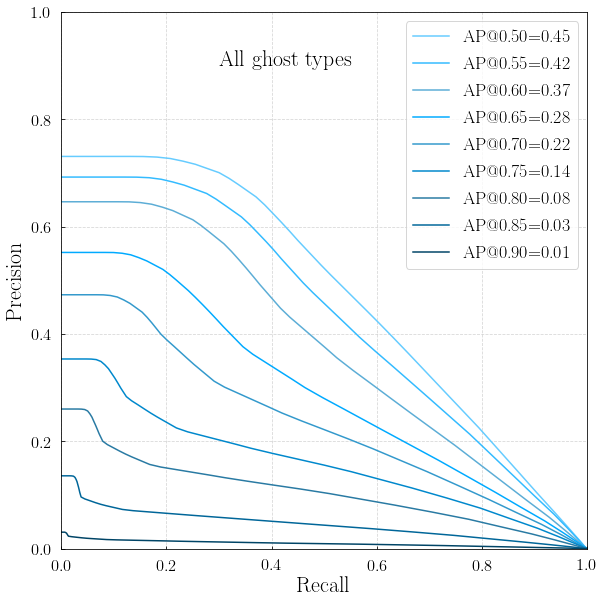

In [ ]:
custom_blues = ["#66CCFF", "#33BBFF","#5CADD6", "#00AAFF","#3399CC", "#0088CC","#297AA3", "#006699", "#004466"]

plt.figure(figsize=(8.5, 8.5))

# Plots
plt.plot(rec_all[0],prec_all[0], c=custom_blues[0], label=r'AP@0.50=0.45')
plt.plot(rec_all[1],prec_all[1], c=custom_blues[1], label=r'AP@0.55=0.42')
plt.plot(rec_all[2],prec_all[2], c=custom_blues[2], label=r'AP@0.60=0.37')
plt.plot(rec_all[3],prec_all[3], c=custom_blues[3], label=r'AP@0.65=0.28')
plt.plot(rec_all[4],prec_all[4], c=custom_blues[4], label=r'AP@0.70=0.22')
plt.plot(rec_all[5],prec_all[5], c=custom_blues[5], label=r'AP@0.75=0.14')
plt.plot(rec_all[6],prec_all[6], c=custom_blues[6], label=r'AP@0.80=0.08')
plt.plot(rec_all[7],prec_all[7], c=custom_blues[7], label=r'AP@0.85=0.03')
plt.plot(rec_all[8],prec_all[8], c=custom_blues[8], label=r'AP@0.90=0.01')

plt.text(0.3,0.9,'All ghost types', fontsize=22)

# Legents, labels, limits etc
plt.xlim(0,1);plt.ylim(0,1)
plt.legend(frameon=True, loc='upper right',ncol=1, fontsize=18)
plt.tick_params(axis='both', labelsize=16.5)
plt.xlabel('Recall',fontsize=22);plt.ylabel('Precision',fontsize=22)
plt.grid(ls='--',alpha=0.5)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Prec_Recal_all.pdf")
#files.download("/content/drive/My Drive/Plots/Prec_Recal_all.pdf")
plt.show()

- Bright

In [ ]:
print("mAPs, bright:", mAP_bright)

mAPs, bright: [0.2832391  0.27264825 0.24928333 0.2299132  0.19577162 0.14424404
 0.10067288 0.03140097 0.00348384]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

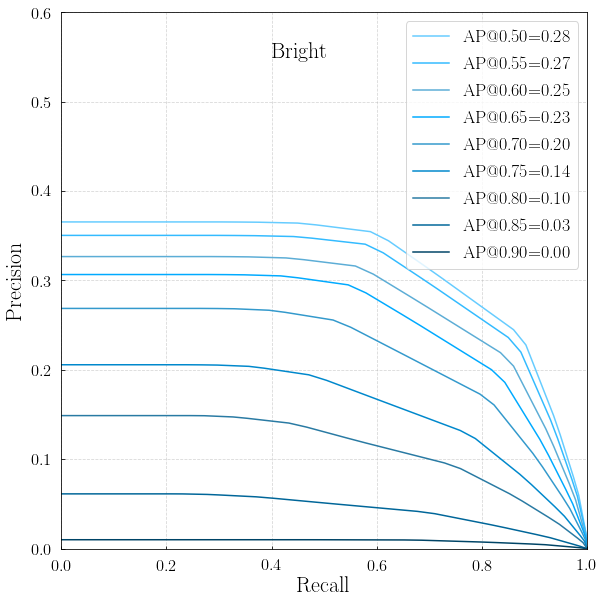

In [ ]:
plt.figure(figsize=(8.5, 8.5))

# Plots
plt.plot(rec_bright[0],prec_bright[0], c=custom_blues[0], label=r'AP@0.50=0.28')
plt.plot(rec_bright[1],prec_bright[1], c=custom_blues[1], label=r'AP@0.55=0.27')
plt.plot(rec_bright[2],prec_bright[2], c=custom_blues[2], label=r'AP@0.60=0.25')
plt.plot(rec_bright[3],prec_bright[3], c=custom_blues[3], label=r'AP@0.65=0.23')
plt.plot(rec_bright[4],prec_bright[4], c=custom_blues[4], label=r'AP@0.70=0.20')
plt.plot(rec_bright[5],prec_bright[5], c=custom_blues[5], label=r'AP@0.75=0.14')
plt.plot(rec_bright[6],prec_bright[6], c=custom_blues[6], label=r'AP@0.80=0.10')
plt.plot(rec_bright[7],prec_bright[7], c=custom_blues[7], label=r'AP@0.85=0.03')
plt.plot(rec_bright[8],prec_bright[8], c=custom_blues[8], label=r'AP@0.90=0.00')

plt.text(0.4,0.55,'Bright', fontsize=22)


# Legents, labels, limits etc
plt.xlim(0,1);plt.ylim(0,0.6)
plt.legend(frameon=True, loc='upper right',ncol=1, fontsize=18)
plt.tick_params(axis='both', labelsize=16.5)
plt.xlabel('Recall',fontsize=22);plt.ylabel('Precision',fontsize=22)
plt.grid(ls='--',alpha=0.5)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Prec_Recal_bright.pdf")
#files.download("/content/drive/My Drive/Plots/Prec_Recal_bright.pdf")
plt.show()

- Faint

In [ ]:
print("mAPs, faint:", mAP_faint)

mAPs, faint: [0.22996629 0.22104767 0.21141371 0.194325   0.17716595 0.14977438
 0.10147051 0.04401975 0.01094123]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

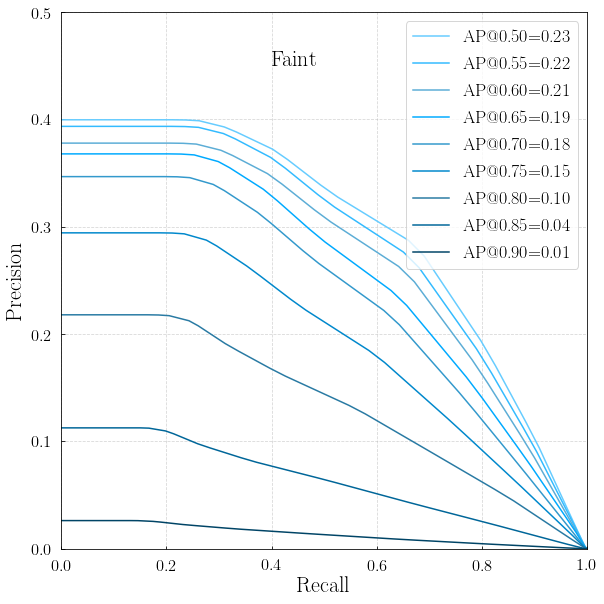

In [ ]:
plt.figure(figsize=(8.5, 8.5))

# Plots
plt.plot(rec_faint[0],prec_faint[0], c=custom_blues[0], label=r'AP@0.50=0.23')
plt.plot(rec_faint[1],prec_faint[1], c=custom_blues[1], label=r'AP@0.55=0.22')
plt.plot(rec_faint[2],prec_faint[2], c=custom_blues[2], label=r'AP@0.60=0.21')
plt.plot(rec_faint[3],prec_faint[3], c=custom_blues[3], label=r'AP@0.65=0.19')
plt.plot(rec_faint[4],prec_faint[4], c=custom_blues[4], label=r'AP@0.70=0.18')
plt.plot(rec_faint[5],prec_faint[5], c=custom_blues[5], label=r'AP@0.75=0.15')
plt.plot(rec_faint[6],prec_faint[6], c=custom_blues[6], label=r'AP@0.80=0.10')
plt.plot(rec_faint[7],prec_faint[7], c=custom_blues[7], label=r'AP@0.85=0.04')
plt.plot(rec_faint[8],prec_faint[8], c=custom_blues[8], label=r'AP@0.90=0.01')

plt.text(0.4,0.45,'Faint', fontsize=22)


# Legents, labels, limits etc
plt.xlim(0,1);plt.ylim(0,0.5)
plt.legend(frameon=True, loc='upper right',ncol=1, fontsize=18)
plt.tick_params(axis='both', labelsize=16.5)
plt.xlabel('Recall',fontsize=22);plt.ylabel('Precision',fontsize=22)
plt.grid(ls='--',alpha=0.5)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Prec_Recal_faint.pdf")
#files.download("/content/drive/My Drive/Plots/Prec_Recal_faint.pdf")
plt.show()

- Rays

In [ ]:
print("mAPs, rays:", mAP_rays)

mAPs, rays: [0.25029729 0.21629506 0.17558528 0.10400409 0.06015422 0.01374954
 0.         0.         0.        ]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

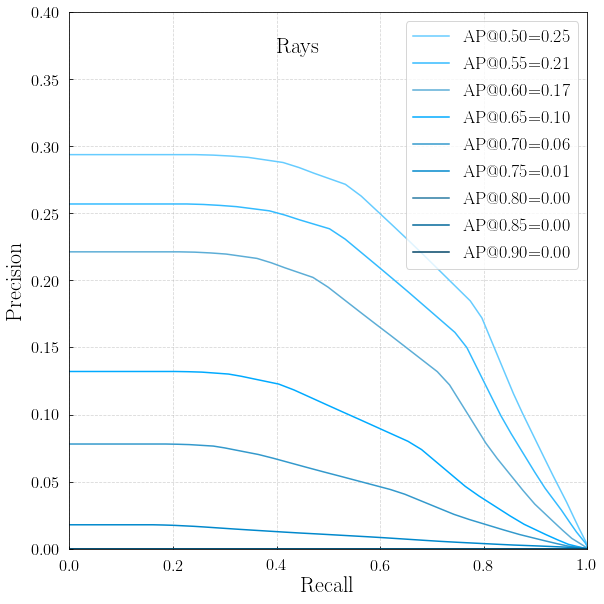

In [ ]:
plt.figure(figsize=(8.5, 8.5))

# Plots
plt.plot(rec_rays[0],prec_rays[0], c=custom_blues[0], label=r'AP@0.50=0.25')
plt.plot(rec_rays[1],prec_rays[1], c=custom_blues[1], label=r'AP@0.55=0.21')
plt.plot(rec_rays[2],prec_rays[2], c=custom_blues[2], label=r'AP@0.60=0.17')
plt.plot(rec_rays[3],prec_rays[3], c=custom_blues[3], label=r'AP@0.65=0.10')
plt.plot(rec_rays[4],prec_rays[4], c=custom_blues[4], label=r'AP@0.70=0.06')
plt.plot(rec_rays[5],prec_rays[5], c=custom_blues[5], label=r'AP@0.75=0.01')
plt.plot(rec_rays[6],prec_rays[6], c=custom_blues[6], label=r'AP@0.80=0.00')
plt.plot(rec_rays[7],prec_rays[7], c=custom_blues[7], label=r'AP@0.85=0.00')
plt.plot(rec_rays[8],prec_rays[8], c=custom_blues[8], label=r'AP@0.90=0.00')

plt.text(0.4,0.37,'Rays', fontsize=22)


# Legents, labels, limits etc
plt.xlim(0,1);plt.ylim(0,0.4)
plt.legend(frameon=True, loc='upper right',ncol=1, fontsize=18)
plt.tick_params(axis='both', labelsize=16.5)
plt.xlabel('Recall',fontsize=22);plt.ylabel('Precision',fontsize=22)
plt.grid(ls='--',alpha=0.5)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Prec_Recal_rays.pdf")
#files.download("/content/drive/My Drive/Plots/Prec_Recal_rays.pdf")
plt.show()

## Part III: Object detection algorithm as a classifier

In this section we use the trained Mask R-CNN algorithm to detect ghosts in images that we know that some of them actually contain ghosts and some of them we know that they do not contain ghosts.

Thus, we treat the Mask R-CNN algorithm as a classifier and we compare with the ground truth labels. We try to investigate if an algorithm trained only on ghost-containing images produces a large number of false positives in images that we know that they do not contain ghosts. (Also produced false negatives by failing to detect ghosts in ghost-containing images)

In [ ]:
filename_x = "x_ghstcln400-tstdat.npy"
filename_y = "y_ghstcln400-tstdat.npy"


X_test = np.load(os.path.join(IMAGE_DIR, filename_x)) #Images
y_test = np.load(os.path.join(IMAGE_DIR, filename_y)) #Labels

In [ ]:
n_test = len(y_test)
print("Size of dataset:", n_test) #The number of objects in the test set

Size of dataset: 1792


In [ ]:
y_pred = np.zeros(n_test) # Initialize array to store the predictions

for i in range(n_test):

  # First, create image
  # =======================================================
  # =======================================================
  X_loc = X_test[i] #Get image
  leng = np.shape(X_loc)[0] #Size of image (400pixels)

  # Initialize image
  # For three channels
  X_ghost_3ch = np.zeros((leng,leng,3))

  #Populate 
  X_ghost_3ch[:,:,0] = X_loc
  X_ghost_3ch[:,:,1] = X_loc
  X_ghost_3ch[:,:,2] = X_loc

  # =======================================================
  # Run predictions 
  # Run detection
  results = model.detect([X_ghost_3ch], verbose=0)
  r = results[0]

  #Get number of ghosts found
  class_ghosts = r['class_ids']
  n_ghosts = len(class_ghosts)

  # Get the number of faint object
  n_faint = len(class_ghosts[class_ghosts==2])

  if ((n_ghosts>0)):
    y_pred[i] = 1.


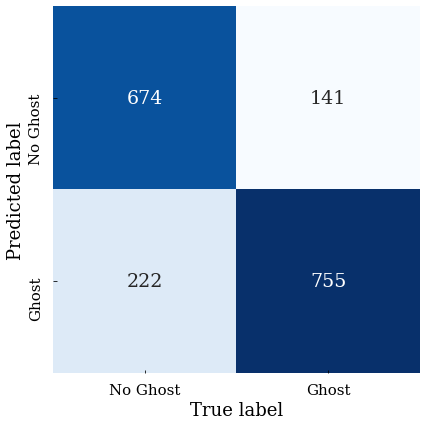

In [ ]:
# Get the confusion matrix
con_mat = confusion_matrix(y_test, y_pred)


class_names = ['No Ghost','Ghost']

plt.figure(figsize = (7,6.0))
g =sns.heatmap(con_mat.T, square = True, annot=True,annot_kws={"size": 19}, fmt='.0f', cmap='Blues', cbar=False, 
           xticklabels= class_names,
           yticklabels= class_names)
g.set_xticklabels(class_names, fontsize = 17)
g.set_yticklabels(class_names, fontsize = 17)

# Ticks for colorbar
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
# =========================================
# =========================================
plt.xlabel('True label',fontsize=18)
plt.ylabel('Predicted label',fontsize=18)

plt.tight_layout()
#plt.savefig("/content/drive/My Drive/Plots/Confusion_Ghosts.pdf")
#files.download("/content/drive/My Drive/Plots/Confusion_Ghosts.pdf")
plt.show()